In [1]:
from datetime import datetime

min_lat, max_lat = 20, 30
min_lon, max_lon = -82, -97
bbox = [min_lon, min_lat, max_lon, max_lat]
crs = 'urn:ogc:def:crs:OGC:1.3:CRS84'

# Temporal range of 1 week.
start = datetime(2017, 4, 14, 0, 0, 0)
stop = datetime(2017, 4, 21, 0, 0, 0)

# Sea surface temperature CF names.
cf_names = ['sea_water_temperature',
            'sea_surface_temperature',
            'sea_water_potential_temperature',
            'equivalent_potential_temperature',
            'sea_water_conservative_temperature',
            'pseudo_equivalent_potential_temperature']

In [2]:
def fes_date_filter(start, stop, constraint='overlaps'):
    from owslib import fes
    start = start.strftime('%Y-%m-%d %H:00')
    stop = stop.strftime('%Y-%m-%d %H:00')
    if constraint == 'overlaps':
        propertyname = 'apiso:TempExtent_begin'
        begin = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname,
                                                literal=stop)
        propertyname = 'apiso:TempExtent_end'
        end = fes.PropertyIsGreaterThanOrEqualTo(propertyname=propertyname,
                                                 literal=start)
    elif constraint == 'within':
        propertyname = 'apiso:TempExtent_begin'
        begin = fes.PropertyIsGreaterThanOrEqualTo(propertyname=propertyname,
                                                   literal=start)
        propertyname = 'apiso:TempExtent_end'
        end = fes.PropertyIsLessThanOrEqualTo(propertyname=propertyname,
                                              literal=stop)
    else:
        raise NameError('Unrecognized constraint {}'.format(constraint))
    return begin, end

In [3]:
from owslib import fes

kw = dict(
    wildCard='*',
    escapeChar='\\',
    singleChar='?',
    propertyname='apiso:AnyText'
)

or_filt = fes.Or(
    [fes.PropertyIsLike(literal=('*%s*' % val), **kw)
        for val in cf_names])

begin, end = fes_date_filter(start, stop)
bbox_crs = fes.BBox(bbox, crs=crs)

filter_list = [
    fes.And(
        [
            bbox_crs,
            begin, end,
            or_filt,
            fes.PropertyIsLike(literal='*CO-OPS*', **kw),
        ]
    )
]

In [4]:
def get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000):
    """Iterate `maxrecords`/`pagesize` times until the requested value in
    `maxrecords` is reached.
    """
    from owslib.fes import SortBy, SortProperty
    # Iterate over sorted results.
    sortby = SortBy([SortProperty('dc:title', 'ASC')])
    csw_records = {}
    startposition = 0
    nextrecord = getattr(csw, 'results', 1)
    while nextrecord != 0:
        csw.getrecords2(constraints=filter_list, startposition=startposition,
                        maxrecords=pagesize, sortby=sortby)
        csw_records.update(csw.records)
        if csw.results['nextrecord'] == 0:
            break
        startposition += pagesize + 1  # Last one is included.
        if startposition >= maxrecords:
            break
    csw.records.update(csw_records)

In [5]:
from owslib.csw import CatalogueServiceWeb


endpoint = 'https://data.ioos.us/csw'

csw = CatalogueServiceWeb(endpoint, timeout=60)

get_csw_records(csw, filter_list, pagesize=10, maxrecords=1000)

records = '\n'.join(csw.records.keys())
print('Found {} records.\n'.format(len(csw.records.keys())))

Found 51 records.



In [6]:
for key, value in list(csw.records.items()):
    print(u'[{}]\n{}\n'.format(value.title, key))

[urn:ioos:station:NOAA.NOS.CO-OPS:t03010 station, Port Manatee]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_t03010

[Apalachicola, FL]
noaa_nos_co_ops_8728690

[Cedar Key, FL]
noaa_nos_co_ops_8727520

[Clearwater Beach, FL]
noaa_nos_co_ops_8726724

[Mckay Bay Entrance, FL]
noaa_nos_co_ops_8726667

[Old Port Tampa, FL]
noaa_nos_co_ops_8726607

[Port Manatee, FL]
noaa_nos_co_ops_8726384

[St Petersburg, FL]
noaa_nos_co_ops_8726520

[urn:ioos:station:NOAA.NOS.CO-OPS:8726384 station, Port Manatee, FL]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_8726384

[urn:ioos:station:NOAA.NOS.CO-OPS:8726520 station, St. Petersburg, Tampa Bay, FL]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_8726520

[urn:ioos:station:NOAA.NOS.CO-OPS:8726607 station, Old Port Tampa, FL]
opendap.co-ops.nos.noaa.gov-urn_ioos_station_NOAA.NOS.CO-OPS_8726607

[urn:ioos:station:NOAA.NOS.CO-OPS:8726667 station, Mckay Bay Entrance, FL]
opendap.co-ops.nos.noaa.gov-urn_ioos_stati

In [7]:
import textwrap


key, value = list(csw.records.items())[-1]

print('\n'.join(textwrap.wrap(value.abstract)))

NOAA.NOS.CO-OPS Sensor Observation Service (SOS) Server  This station
provides the following variables: Direction of sea water velocity,
Platform orientation, Platform pitch angle, Platform roll angle, Sea
water speed, Sea water temperature


In [8]:
print('\n'.join(value.subjects))

Air Temperature
Barometric Pressure
Conductivity
Currents
Datum
Harmonic Constituents
Rain Fall
Relative Humidity
Salinity
Visibility
Water Level
Water Level Predictions
Water Temperature
Winds
direction_of_sea_water_velocity
platform_orientation
platform_pitch_angle
platform_roll_angle
sea_water_speed
sea_water_temperature
climatologyMeteorologyAtmosphere


In [9]:
from geolinks import sniff_link

msg = 'geolink: {geolink}\nscheme: {scheme}\nURL: {url}\n'.format
for ref in value.references:
    print(msg(geolink=sniff_link(ref['url']), **ref))

geolink: OGC:SOS
scheme: Port Arthur
URL: https://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?service=SOS&version=1.0.0&procedure=urn:ioos:station:NOAA.NOS.CO-OPS:sn0701&request=DescribeSensor&outputFormat=text/xml; subtype="sensorML/1.0.1/profiles/ioos_sos/1.0"

geolink: OGC:SOS
scheme: WWW:LINK - text/csv
URL: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?responseFormat=text/csv&request=GetObservation&observedProperty=http://mmisw.org/ont/cf/parameter/direction_of_sea_water_velocity&eventTime=2018-07-11T16:10:29/2018-07-11T18:10:29&offering=urn:ioos:station:NOAA.NOS.CO-OPS:sn0701&service=SOS&version=1.0.0

geolink: OGC:SOS
scheme: WWW:LINK - text/csv
URL: http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?responseFormat=text/csv&request=GetObservation&observedProperty=http://mmisw.org/ont/cf/parameter/platform_orientation&eventTime=2018-07-11T16:10:29/2018-07-11T18:10:29&offering=urn:ioos:station:NOAA.NOS.CO-OPS:sn0701&service=SOS&version=1.0.0

geolink: OGC:SOS
scheme: WWW:L

In [10]:
fmt = ('http://opendap.co-ops.nos.noaa.gov/ioos-dif-sos/SOS?'
       'service=SOS&'
       'eventTime={0:%Y-%m-%dT00:00:00}/{1:%Y-%m-%dT00:00:00}&'
       'observedProperty=http://mmisw.org/ont/cf/parameter/sea_water_temperature&'
       'version=1.0.0&'
       f'request=GetObservation&offering=urn:ioos:station:NOAA.NOS.CO-OPS:8771450&'
       'responseFormat=text/csv')

url = fmt.format(start, stop)

In [11]:
import pandas as pd

df = pd.read_csv(
    url,
    index_col='date_time', parse_dates=True
)

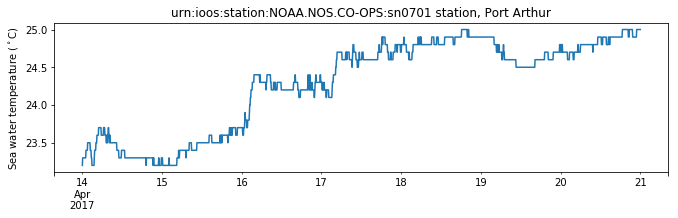

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(11, 2.75))
ax = df['sea_water_temperature (C)'].plot(ax=ax)
ax.set_xlabel('')
ax.set_ylabel(r'Sea water temperature ($^\circ$C)')
ax.set_title(value.title);